In [3]:
import doctest
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.datasets import make_blobs
from scipy.stats import multivariate_normal
from matplotlib.patches import Ellipse
from sklearn.neighbors import NearestNeighbors
#from geopy.distance import geodesic
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
import umap.umap_ as umap
#from umap import UMAP
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
#from leidenalg import find_partition
#import networkx as nx

# two useful data viz libraries
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.cluster as cluster
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.mixture import GaussianMixture
from sklearn.cluster import SpectralClustering
from kneed import KneeLocator
from sklearn.model_selection import ParameterGrid
from sklearn.cluster import DBSCAN
import hdbscan
from sklearn.cluster import HDBSCAN
# setup plotting in a notebook in a reasonable way
%matplotlib inline
%config InlineBackend.figure_format='retina'

# default figure aesthetics I'll be using, 
# there are other choices, see seaborn docs
sns.set_style("white")
sns.set_context("notebook")

In [4]:
plt.style.use('dark_background')

# Read in data

In [5]:
housing_data_df = pd.read_csv(r'clean_housing_data_with_crime_rates.csv')
housing_data_df

,State,City,Street,Zipcode,Bedroom,Bathroom,Area,PPSq,LotArea,MarketEstimate,...,house_coordinates,closest_city,city_coordinates,distance_to_maj_city_miles,population_y,violent_crime,prop_crime,larceny,vehicle_theft,difference_listed_vs_estimate
0,AL,Montgomery,Brampton Ln,36117.0,3.0,2.0,1564.0,96.547315,0.2000,150500.0,...,"(32.372746, -86.165115)",Birmingham,"(33.5279, -86.7971)",87.664428,209018.0,0.001893,0.027600,0.017277,0.002520,500.0
1,AL,Montgomery,Crestview Ave,36109.0,3.0,2.0,2196.0,76.958106,0.6100,124700.0,...,"(32.39595, -86.269714)",Birmingham,"(33.5279, -86.7971)",83.806091,209018.0,0.001893,0.027600,0.017277,0.002520,44300.0
2,AL,Montgomery,Narrow Lane Rd,36116.0,3.0,3.0,3693.0,54.156512,6.9000,188300.0,...,"(32.273514, -86.25934)",Birmingham,"(33.5279, -86.7971)",91.920847,209018.0,0.001893,0.027600,0.017277,0.002520,11700.0
3,AL,Montgomery,E Delano Ave,36105.0,3.0,2.0,1428.0,90.966387,0.2600,127500.0,...,"(32.337, -86.29974)",Birmingham,"(33.5279, -86.7971)",87.007986,209018.0,0.001893,0.027600,0.017277,0.002520,2400.0
4,AL,Montgomery,George B Edmondson Dr,36110.0,3.0,1.0,1050.0,65.714286,0.1600,66500.0,...,"(32.40325, -86.28537)",Birmingham,"(33.5279, -86.7971)",83.007626,209018.0,0.001893,0.027600,0.017277,0.002520,2500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9631,WY,Green River,Colorado Dr,82935.0,5.0,3.0,3068.0,128.748370,0.2200,381000.0,...,"(41.494328, -109.45258)",Provo,"(40.2457, -111.6457)",143.591563,11927.0,0.001845,0.008133,0.007043,0.000168,14000.0
9632,WY,Evansville,Henrie Roadway,82636.0,2.0,2.0,2008.0,343.625498,4.6000,689900.0,...,"(42.86057, -106.10931)",Denver,"(39.762, -104.8758)",223.247715,2977.0,0.002351,0.024521,0.017467,0.002687,100.0
9633,WY,Evansville,6th St,82636.0,4.0,2.0,2022.0,157.270030,0.1828,311100.0,...,"(42.86506, -106.27643)",Denver,"(39.762, -104.8758)",226.191583,2977.0,0.002351,0.024521,0.017467,0.002687,6900.0
9634,WY,Evansville,6th St,82636.0,3.0,3.0,2300.0,143.434783,0.1739,329500.0,...,"(42.86544, -106.27745)",Denver,"(39.762, -104.8758)",226.233434,2977.0,0.002351,0.024521,0.017467,0.002687,400.0


In [6]:
# manipulating coordinates to be two separate variables + in separate columns for location purposes
housing_df_revised = housing_data_df[['Bedroom', 'Bathroom', 'Area', 'PPSq', 'LotArea', 'MarketEstimate', 'RentEstimate', 'ListedPrice', 'difference_listed_vs_estimate', 'house_coordinates', 'distance_to_maj_city_miles', 'violent_crime', 'prop_crime', 'larceny', 'vehicle_theft']]
housing_df_revised['x_house_coord'], housing_df_revised['y_house_coord'] = zip(*(housing_df_revised['house_coordinates'].str.strip('()').str.split(', ')))
housing_df_revised['x_house_coord'] = housing_df_revised['x_house_coord'].astype(float)
housing_df_revised['y_house_coord'] = housing_df_revised['y_house_coord'].astype(float)
housing_df_revised.drop(columns=['house_coordinates'], inplace=True)

/var/folders/dr/_3zwgynx02q1l6yd2z7c_p3w0000gn/T/ipykernel_40829/1025807139.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  housing_df_revised['x_house_coord'], housing_df_revised['y_house_coord'] = zip(*(housing_df_revised['house_coordinates'].str.strip('()').str.split(', ')))
/var/folders/dr/_3zwgynx02q1l6yd2z7c_p3w0000gn/T/ipykernel_40829/1025807139.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  housing_df_revised['x_house_coord'], housing_df_revised['y_house_coord'] = zip(*(housing_df_revised['

In [7]:
housing_df_revised.columns

Index(['Bedroom', 'Bathroom', 'Area', 'PPSq', 'LotArea', 'MarketEstimate',
       'RentEstimate', 'ListedPrice', 'difference_listed_vs_estimate',
       'distance_to_maj_city_miles', 'violent_crime', 'prop_crime', 'larceny',
       'vehicle_theft', 'x_house_coord', 'y_house_coord'],
      dtype='object')

In [8]:
# validate variable types
for var in housing_df_revised.columns:
    print(type(housing_df_revised[var][0]))

<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.float64'>


In [9]:
#convert housing_df to matrix
housing_df_matrix = housing_df_revised.values
housing_df_matrix

array([[ 3.00000000e+00,  2.00000000e+00,  1.56400000e+03, ...,
         2.51987867e-03,  3.23727460e+01, -8.61651150e+01],
       [ 3.00000000e+00,  2.00000000e+00,  2.19600000e+03, ...,
         2.51987867e-03,  3.23959500e+01, -8.62697140e+01],
       [ 3.00000000e+00,  3.00000000e+00,  3.69300000e+03, ...,
         2.51987867e-03,  3.22735140e+01, -8.62593400e+01],
       ...,
       [ 4.00000000e+00,  2.00000000e+00,  2.02200000e+03, ...,
         2.68726906e-03,  4.28650600e+01, -1.06276430e+02],
       [ 3.00000000e+00,  3.00000000e+00,  2.30000000e+03, ...,
         2.68726906e-03,  4.28654400e+01, -1.06277450e+02],
       [ 4.00000000e+00,  2.00000000e+00,  2.12000000e+03, ...,
         2.51572327e-03,  4.28510060e+01, -1.06391810e+02]])

In [10]:
#check matrix shape
housing_df_matrix.shape

(9636, 16)

In [11]:
# scale the data
from sklearn.preprocessing import StandardScaler, OneHotEncoder
housing_df_matrix_scaled = StandardScaler().fit_transform(housing_df_matrix)
housing_df_matrix_scaled

array([[-0.4814257 , -0.4347257 , -0.48396757, ...,  0.00788337,
        -1.17647656,  0.61492104],
       [-0.4814257 , -0.4347257 ,  0.06374335, ...,  0.00788337,
        -1.17287415,  0.60886483],
       [-0.4814257 ,  0.52771355,  1.36109027, ...,  0.00788337,
        -1.19188226,  0.60946548],
       ...,
       [ 0.55568989, -0.4347257 , -0.08705048, ...,  0.08986651,
         0.45244856, -0.54951121],
       [-0.4814257 ,  0.52771355,  0.153873  , ...,  0.08986651,
         0.45250755, -0.54957027],
       [ 0.55568989, -0.4347257 , -0.00212062, ...,  0.00584817,
         0.45026668, -0.55619164]])

# Dimension reduction using PCA

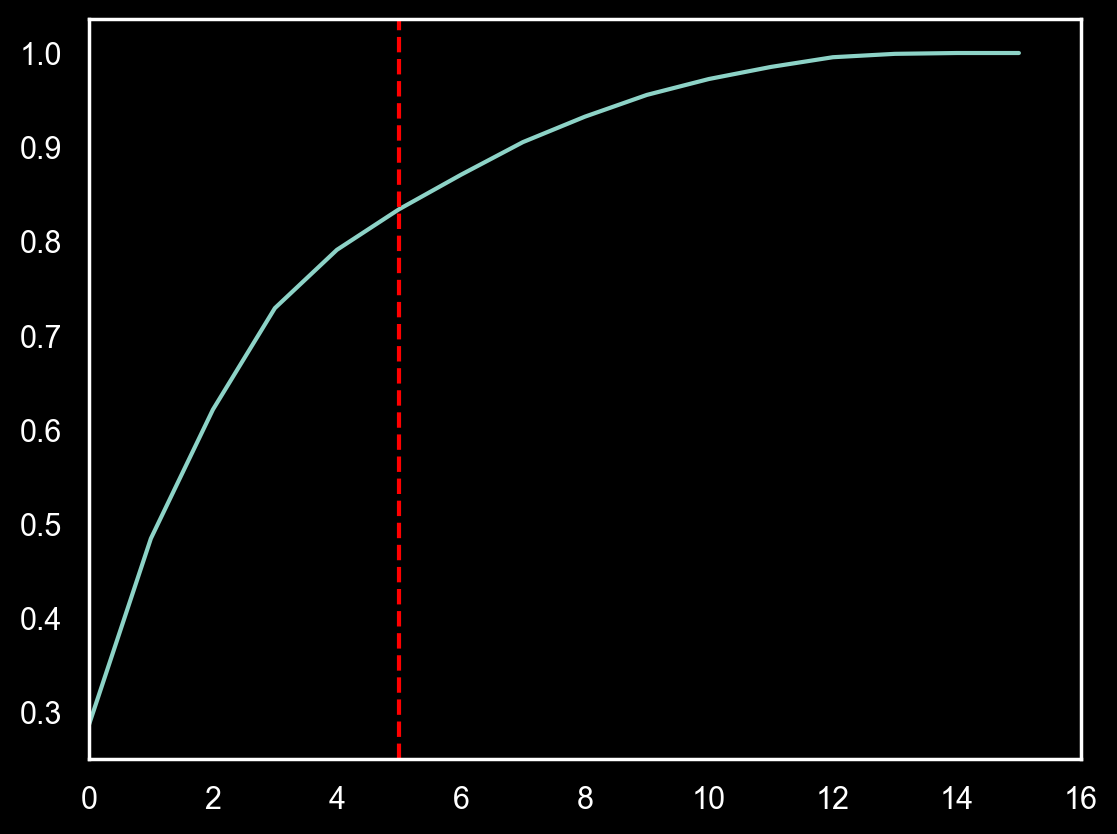

In [12]:
# find elbow point for optimal number of dimensions
dimred = PCA()
dimred.fit(housing_df_matrix_scaled)
sns.lineplot(np.cumsum(dimred.explained_variance_ratio_))
location = KneeLocator(range(1, len(dimred.explained_variance_ratio_) + 1),
                       np.cumsum(dimred.explained_variance_ratio_),
                       curve="concave", direction="increasing")
plt.axvline(location.elbow, color="red", linestyle="--")
plt.xlim((0,16));

In [13]:
# reduce down to 5 dimensions
dimred = PCA(n_components=5)
X = dimred.fit_transform(housing_df_matrix_scaled)

/Users/elizabethlee/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


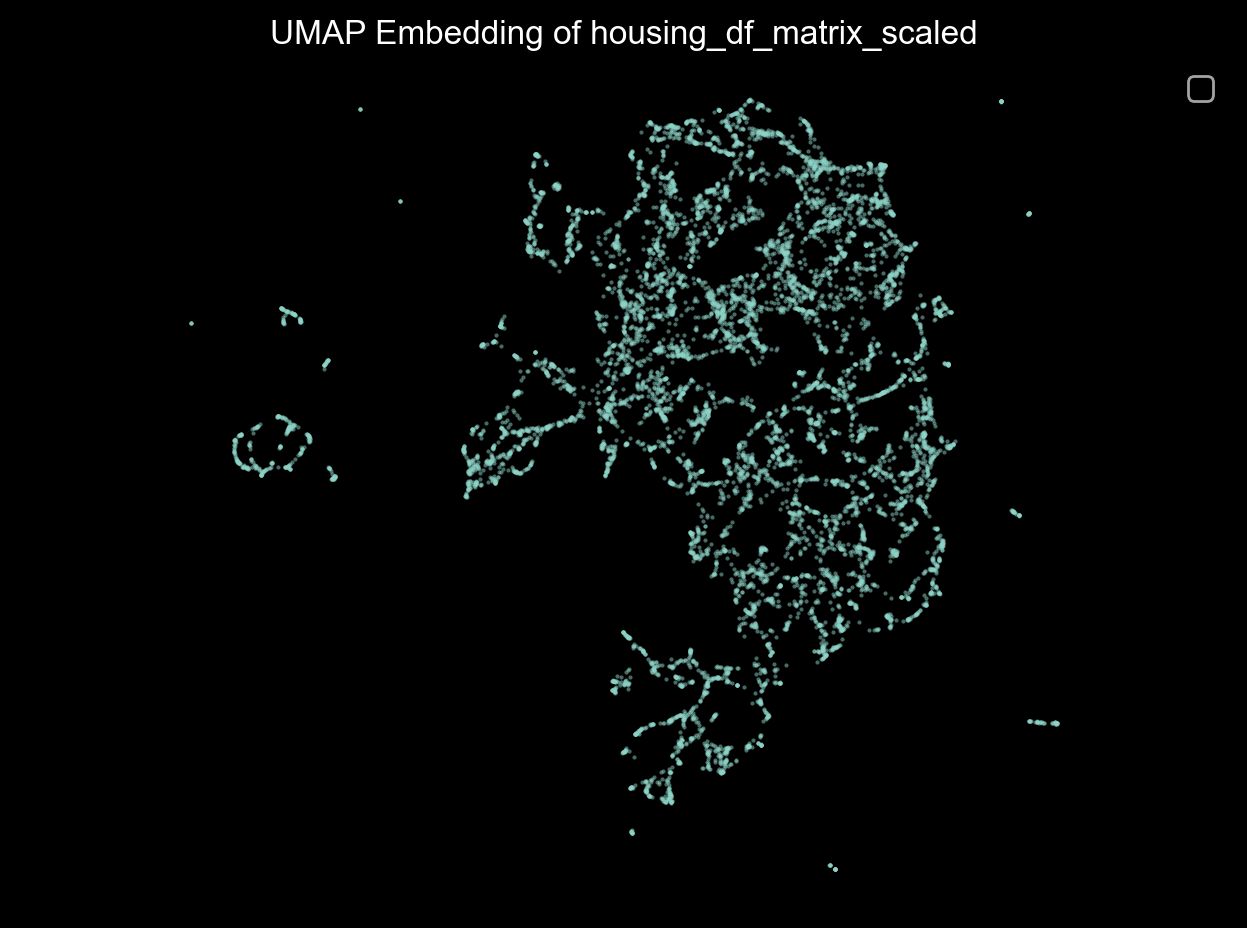

In [14]:
# generate umap of 5 dimensional pca data
umap_model = umap.UMAP(n_neighbors=7, min_dist=0.1, metric='euclidean', random_state = 99, init = 'spectral')
umap_result = umap_model.fit_transform(X)
plt.scatter(umap_result[:, 0], umap_result[:, 1], marker='.', alpha=0.5, s = 1)
plt.title('UMAP Embedding of housing_df_matrix_scaled')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.axis("off")
plt.axis("equal")
plt.legend()
plt.tight_layout()
plt.show()

# Generate clusters

## Gaussian mixture models (GMM)

#### Find number of clusters to cluster

In [15]:
# calculate the silhouette scores with different number of clusters
range_n_clusters = [2 ,3, 4, 5, 6, 7, 8, 9, 10]

for n_clusters in range_n_clusters:
    clusterer = GaussianMixture(n_components=n_clusters)
    clusterer.fit(X)
    cluster_labels = clusterer.predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

For n_clusters = 2 The average silhouette_score is : 0.3538328866569088
For n_clusters = 3 The average silhouette_score is : 0.18458465952506342
For n_clusters = 4 The average silhouette_score is : 0.20096480485411772
For n_clusters = 5 The average silhouette_score is : 0.10060196186667562
For n_clusters = 6 The average silhouette_score is : 0.19181882786932886
For n_clusters = 7 The average silhouette_score is : 0.13240735400699147
For n_clusters = 8 The average silhouette_score is : 0.11844360532667321
For n_clusters = 9 The average silhouette_score is : 0.07997309378436919
For n_clusters = 10 The average silhouette_score is : 0.08144359337319716


Text(0.5, 1.0, 'Selecting number of clusters via elbow')

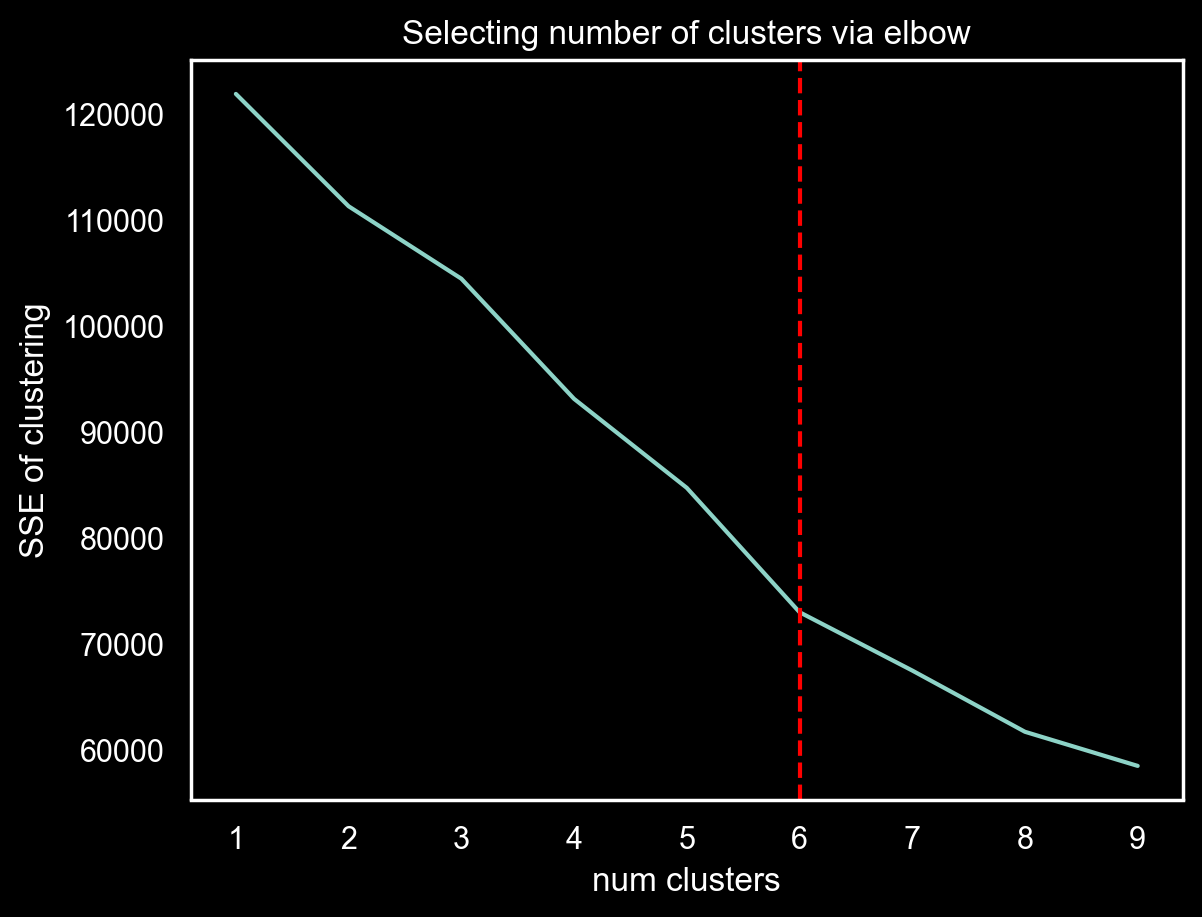

In [18]:
# generate elbow plot for optimal number of clusters
sse=[]
maxk = 10
for k in range(1,maxk):
    clust = GaussianMixture(n_components=k)
    clust.fit(X)
    
    distances = []
    for i, center in enumerate(clust.means_):
        distances.append(np.sum((X[clust.predict(X) == i] - center) ** 2))
    
    # Sum the squared distances to get the SSE
    sse.append(np.sum(distances)) 

# finds the location of max curvature (max of double derivative)
location = KneeLocator(range(1,maxk), sse, S=1.0, curve="convex", direction="decreasing")

plt.plot(range(1,maxk),sse)
plt.axvline(location.elbow, color="red", linestyle="--")

plt.xlabel('num clusters')
plt.ylabel('SSE of clustering')
plt.title('Selecting number of clusters via elbow')

#### Generate GMM clusters

In [19]:
# try 3 clusters
# note: inconsistencies between silhoutte scores and elbow point
# elbow point consistently changed each time it ran
# silhouette scores remained roughly the same across multiple runs
clusterer_gmm = GaussianMixture(n_components=3)
clusterer_gmm.fit(X)
cluster_labels_gmm = clusterer_gmm.predict(X)

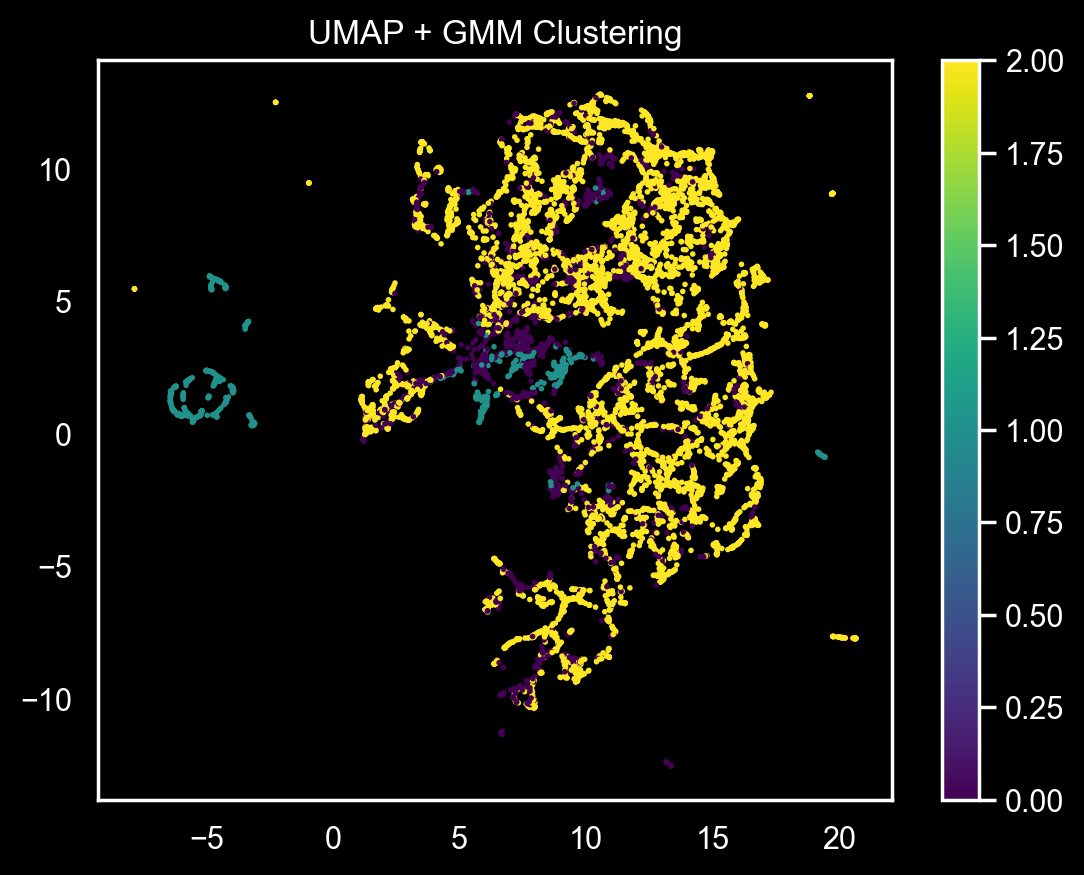

In [20]:
# generate umap with GMM clusters
# note: visualiztion of 6 dimensional data down to 2 dimensions may not show clearly defined clusters
# however, we must look at the actual data to see if it makes sense
plt.scatter(umap_result[:, 0], umap_result[:, 1], c=cluster_labels_gmm, cmap='viridis', s = 1)
plt.title('UMAP + GMM Clustering')
plt.colorbar()
plt.show()

#### Look at dataframe to see if clusters make sense

In [21]:
# add column to housing_df_revised with gmm cluster label for each point
housing_df_revised['gmm clusters'] = cluster_labels_gmm
housing_df_revised

/var/folders/dr/_3zwgynx02q1l6yd2z7c_p3w0000gn/T/ipykernel_40829/826957943.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  housing_df_revised['gmm clusters'] = cluster_labels_gmm


,Bedroom,Bathroom,Area,PPSq,LotArea,MarketEstimate,RentEstimate,ListedPrice,difference_listed_vs_estimate,distance_to_maj_city_miles,violent_crime,prop_crime,larceny,vehicle_theft,x_house_coord,y_house_coord,gmm clusters
0,3.0,2.0,1564.0,96.547315,0.2000,150500.0,1385.0,151000.0,500.0,87.664428,0.001893,0.027600,0.017277,0.002520,32.372746,-86.165115,2
1,3.0,2.0,2196.0,76.958106,0.6100,124700.0,1250.0,169000.0,44300.0,83.806091,0.001893,0.027600,0.017277,0.002520,32.395950,-86.269714,2
2,3.0,3.0,3693.0,54.156512,6.9000,188300.0,1201.0,200000.0,11700.0,91.920847,0.001893,0.027600,0.017277,0.002520,32.273514,-86.259340,0
3,3.0,2.0,1428.0,90.966387,0.2600,127500.0,1019.0,129900.0,2400.0,87.007986,0.001893,0.027600,0.017277,0.002520,32.337000,-86.299740,2
4,3.0,1.0,1050.0,65.714286,0.1600,66500.0,950.0,69000.0,2500.0,83.007626,0.001893,0.027600,0.017277,0.002520,32.403250,-86.285370,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9631,5.0,3.0,3068.0,128.748370,0.2200,381000.0,2495.0,395000.0,14000.0,143.591563,0.001845,0.008133,0.007043,0.000168,41.494328,-109.452580,2
9632,2.0,2.0,2008.0,343.625498,4.6000,689900.0,1672.0,690000.0,100.0,223.247715,0.002351,0.024521,0.017467,0.002687,42.860570,-106.109310,0
9633,4.0,2.0,2022.0,157.270030,0.1828,311100.0,1895.0,318000.0,6900.0,226.191583,0.002351,0.024521,0.017467,0.002687,42.865060,-106.276430,2
9634,3.0,3.0,2300.0,143.434783,0.1739,329500.0,1614.0,329900.0,400.0,226.233434,0.002351,0.024521,0.017467,0.002687,42.865440,-106.277450,2


In [22]:
# run groupby function by 'gmm clusters' to see mean of each cluster
housing_df_revised.groupby('gmm clusters').mean()

,Bedroom,Bathroom,Area,PPSq,LotArea,MarketEstimate,RentEstimate,ListedPrice,difference_listed_vs_estimate,distance_to_maj_city_miles,violent_crime,prop_crime,larceny,vehicle_theft,x_house_coord,y_house_coord
gmm clusters,,,,,,,,,,,,,,,,
0,3.717525,2.896936,2692.238358,285.913438,1.908587,6.627922e+05,3259.992034,6.709438e+05,8151.690564,91.681890,0.004470,0.031501,0.023873,0.002708,39.066601,-97.074924
1,3.668097,3.170243,3093.954220,388.793673,7.786859,1.404168e+06,5890.038627,1.487063e+06,82894.296137,821.576931,0.005612,0.033549,0.025565,0.003147,51.733939,-126.212861
2,3.388090,2.283463,1902.189185,180.074067,0.301260,3.275635e+05,2073.331828,3.301073e+05,2543.824093,89.094711,0.004167,0.026253,0.019631,0.002397,39.020736,-93.905170


In [23]:
# check how many points are in each cluster
for i in housing_df_revised['gmm clusters'].unique():
    shape = housing_df_revised[housing_df_revised['gmm clusters'] == i].shape[0]
    print (f'Cluster {i} has {shape} observations')

Cluster 2 has 7305 observations
Cluster 0 has 1632 observations
Cluster 1 has 699 observations


- Observations
    - Difference in cluster sizes is not optimal
    - We can clearly see a relationship differenting between the clusters however

## K-means

#### Find the number of clusters to cluster

In [24]:
# calculate silhouette scores
range_n_clusters = [2,3, 4, 5, 6, 7, 8, 9, 10]

for n_clusters in range_n_clusters:
    clusterer = cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

/Users/elizabethlee/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 2 The average silhouette_score is : 0.880575137134847


/Users/elizabethlee/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 3 The average silhouette_score is : 0.3175179937811755


/Users/elizabethlee/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 4 The average silhouette_score is : 0.317257626301423


/Users/elizabethlee/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 5 The average silhouette_score is : 0.32310552091204375


/Users/elizabethlee/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 6 The average silhouette_score is : 0.2868540559598267


/Users/elizabethlee/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 7 The average silhouette_score is : 0.2435558379166847


/Users/elizabethlee/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 8 The average silhouette_score is : 0.2468316706450492


/Users/elizabethlee/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 9 The average silhouette_score is : 0.233509523558292


/Users/elizabethlee/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 10 The average silhouette_score is : 0.2502712625036268


/Users/elizabethlee/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/elizabethlee/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/elizabethlee/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/elizabethlee/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packa

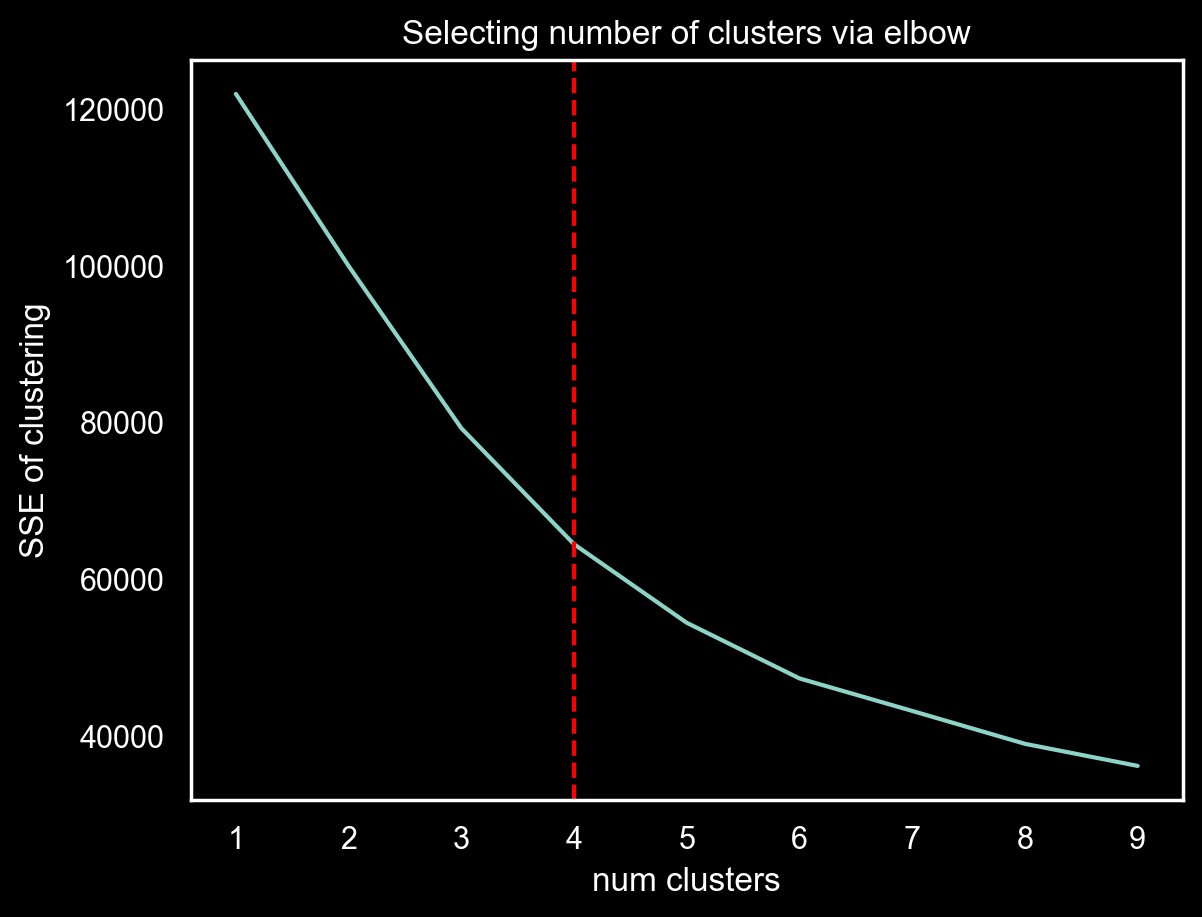

In [25]:
# plot the elbow point
sse=[]
maxk = 10
for k in range(1,maxk):
    clust = cluster.KMeans(n_clusters=k)
    clust.fit(X)
    sse.append(clust.inertia_)

# finds the location of max curvature (max of double derivative)
location = KneeLocator(range(1,maxk), sse, S=1.0, curve="convex", direction="decreasing")

plt.plot(range(1,maxk),sse)
plt.axvline(location.elbow, color="red", linestyle="--")

plt.xlabel('num clusters')
plt.ylabel('SSE of clustering')
plt.title('Selecting number of clusters via elbow');

#### Generate K-means clusters

/Users/elizabethlee/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


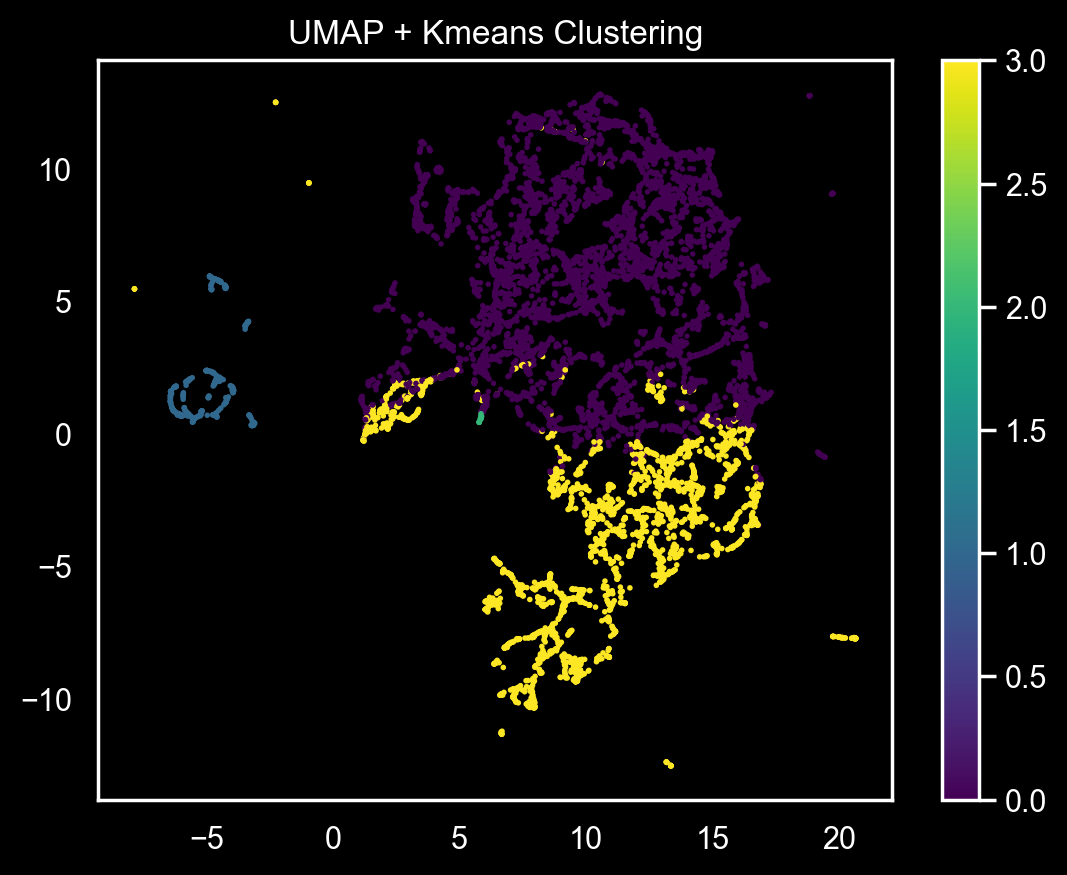

In [26]:
# try 4 clusters
# note: though 2 clusters has the highest silhouette score, our model does not make sense with 2 clusters
# we chose to use elbow point as the number of clusters
# elbow point of 4 has also relativly high silhouette score with score of 0.317
clusterer_kmeans = cluster.KMeans(n_clusters=4, random_state=10)
cluster_labels_kmeans = clusterer_kmeans.fit_predict(X)
plt.scatter(umap_result[:, 0], umap_result[:, 1], c=cluster_labels_kmeans, cmap='viridis', s = 1)
plt.title('UMAP + Kmeans Clustering')
plt.colorbar()
plt.show()

#### Look at dataframe to see if clusters make sense

In [27]:
# add column to housing_df_revised with kmeans cluster label for each point
housing_df_revised['kmeans clusters'] = cluster_labels_kmeans
housing_df_revised

/var/folders/dr/_3zwgynx02q1l6yd2z7c_p3w0000gn/T/ipykernel_40829/3257396536.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  housing_df_revised['kmeans clusters'] = cluster_labels_kmeans


,Bedroom,Bathroom,Area,PPSq,LotArea,MarketEstimate,RentEstimate,ListedPrice,difference_listed_vs_estimate,distance_to_maj_city_miles,violent_crime,prop_crime,larceny,vehicle_theft,x_house_coord,y_house_coord,gmm clusters,kmeans clusters
0,3.0,2.0,1564.0,96.547315,0.2000,150500.0,1385.0,151000.0,500.0,87.664428,0.001893,0.027600,0.017277,0.002520,32.372746,-86.165115,2,0
1,3.0,2.0,2196.0,76.958106,0.6100,124700.0,1250.0,169000.0,44300.0,83.806091,0.001893,0.027600,0.017277,0.002520,32.395950,-86.269714,2,0
2,3.0,3.0,3693.0,54.156512,6.9000,188300.0,1201.0,200000.0,11700.0,91.920847,0.001893,0.027600,0.017277,0.002520,32.273514,-86.259340,0,0
3,3.0,2.0,1428.0,90.966387,0.2600,127500.0,1019.0,129900.0,2400.0,87.007986,0.001893,0.027600,0.017277,0.002520,32.337000,-86.299740,2,0
4,3.0,1.0,1050.0,65.714286,0.1600,66500.0,950.0,69000.0,2500.0,83.007626,0.001893,0.027600,0.017277,0.002520,32.403250,-86.285370,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9631,5.0,3.0,3068.0,128.748370,0.2200,381000.0,2495.0,395000.0,14000.0,143.591563,0.001845,0.008133,0.007043,0.000168,41.494328,-109.452580,2,0
9632,2.0,2.0,2008.0,343.625498,4.6000,689900.0,1672.0,690000.0,100.0,223.247715,0.002351,0.024521,0.017467,0.002687,42.860570,-106.109310,0,0
9633,4.0,2.0,2022.0,157.270030,0.1828,311100.0,1895.0,318000.0,6900.0,226.191583,0.002351,0.024521,0.017467,0.002687,42.865060,-106.276430,2,0
9634,3.0,3.0,2300.0,143.434783,0.1739,329500.0,1614.0,329900.0,400.0,226.233434,0.002351,0.024521,0.017467,0.002687,42.865440,-106.277450,2,0


In [28]:
# run groupby function by 'kmeans clusters' to see mean of each cluster
housing_df_revised.groupby('kmeans clusters').mean()

,Bedroom,Bathroom,Area,PPSq,LotArea,MarketEstimate,RentEstimate,ListedPrice,difference_listed_vs_estimate,distance_to_maj_city_miles,violent_crime,prop_crime,larceny,vehicle_theft,x_house_coord,y_house_coord,gmm clusters
kmeans clusters,,,,,,,,,,,,,,,,,
0,3.520571,2.500000,2181.729235,220.621580,1.267820,4.770664e+05,2581.540755,4.831147e+05,6.048289e+03,95.408787,0.002625,0.018850,0.014537,0.001503,39.564897,-95.165422,1.619624
1,3.310345,2.448276,2108.625995,233.399305,1.371973,4.674456e+05,2653.021220,4.778091e+05,1.036347e+04,1407.865912,0.007542,0.041806,0.031727,0.004132,61.789083,-147.997361,1.000000
2,5.470588,7.529412,9774.117647,1993.829370,9.848460,1.526199e+07,59567.000000,1.712429e+07,1.862306e+06,50.267947,0.002452,0.014922,0.011814,0.001261,38.564646,-103.001681,1.000000
3,3.343092,2.310246,1941.545519,182.402119,0.681131,3.382991e+05,2121.599786,3.437636e+05,5.464494e+03,81.612275,0.007808,0.046131,0.033719,0.004593,37.907037,-93.580800,1.600500


In [29]:
# check how many points are in each cluster
for i in housing_df_revised['kmeans clusters'].unique():
    shape = housing_df_revised[housing_df_revised['kmeans clusters'] == i].shape[0]
    print (f'Cluster {i} has {shape} observations')

Cluster 0 has 6441 observations
Cluster 3 has 2801 observations
Cluster 1 has 377 observations
Cluster 2 has 17 observations


- Observations
    - Cluster 0 and 3 have decent cluster sizes
    - however cluster size drastically drops off for clusters 1 and 2
    - looking at the means of each cluster however, there is clear distinguished difference between clusters

## DBSCAN

#### Find the number of clusters to cluster

eps: 1, min_samples: 25
number of cluster : 2
number of noise : 808
eps: 1, min_samples: 30
number of cluster : 2
number of noise : 858
eps: 1, min_samples: 35
number of cluster : 2
number of noise : 917
eps: 1.25, min_samples: 25
number of cluster : 2
number of noise : 479
eps: 1.25, min_samples: 30
number of cluster : 2
number of noise : 494
eps: 1.25, min_samples: 35
number of cluster : 3
number of noise : 528
eps: 1.75, min_samples: 25
number of cluster : 2
number of noise : 271
eps: 1.75, min_samples: 30
number of cluster : 2
number of noise : 276
eps: 1.75, min_samples: 35
number of cluster : 2
number of noise : 286


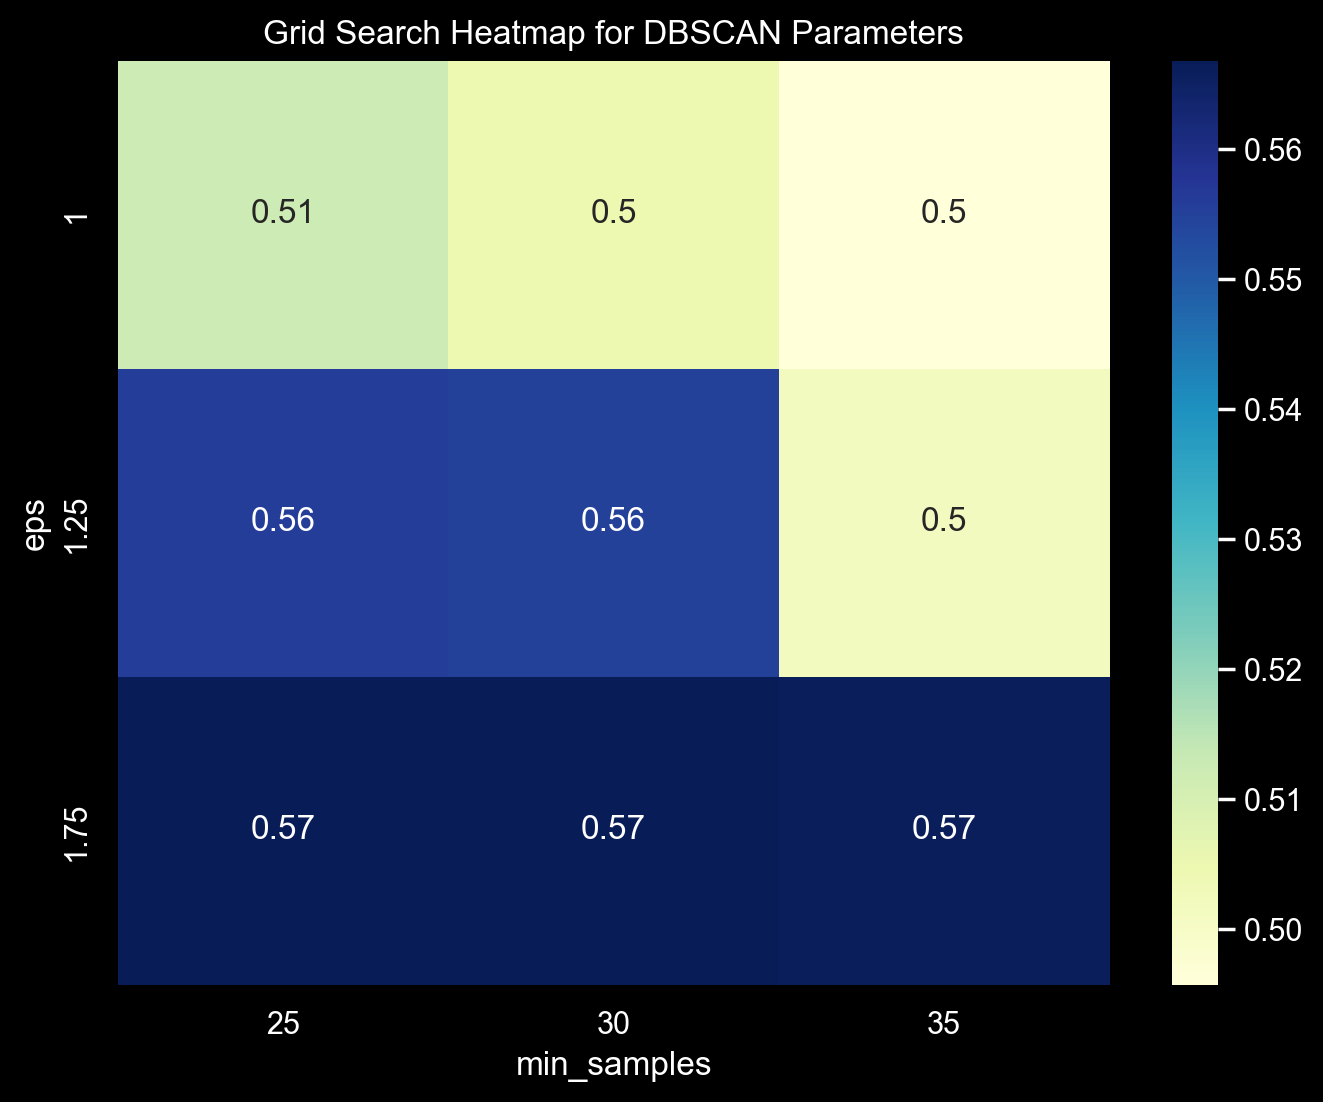

In [30]:
# decide parameters using gridsearch
# Define parameter grid
param_grid = {'eps': [1, 1.25, 1.75],
              'min_samples': [25, 30 ,35]}

# Initialize arrays to store silhouette scores
silhouette_scores = np.zeros((len(param_grid['eps']), len(param_grid['min_samples'])))

# Iterate over parameter combinations
for i, params in enumerate(ParameterGrid(param_grid)):
    # Fit DBSCAN with current parameter combination
    dbscan = DBSCAN(**params)
    dbscan.fit(X)
    labels = dbscan.fit_predict(X)
    n_clusters_ = len(set(labels))-(1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    
    eps_value = params['eps']
    min_samples_value = params['min_samples']
    
    print(f"eps: {eps_value}, min_samples: {min_samples_value}")
    print (f'number of cluster : {n_clusters_}')
    print (f'number of noise : {n_noise_}') 
    
    # Compute silhouette score
    silhouette_avg = silhouette_score(X, dbscan.labels_)
    silhouette_scores[i // len(param_grid['min_samples']), i % len(param_grid['min_samples'])] = silhouette_avg

# Create heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(silhouette_scores, annot=True, cmap="YlGnBu", xticklabels=param_grid['min_samples'], yticklabels=param_grid['eps'])
plt.xlabel('min_samples')
plt.ylabel('eps')
plt.title('Grid Search Heatmap for DBSCAN Parameters')
plt.show()

#### Generate DBSCAN clusters

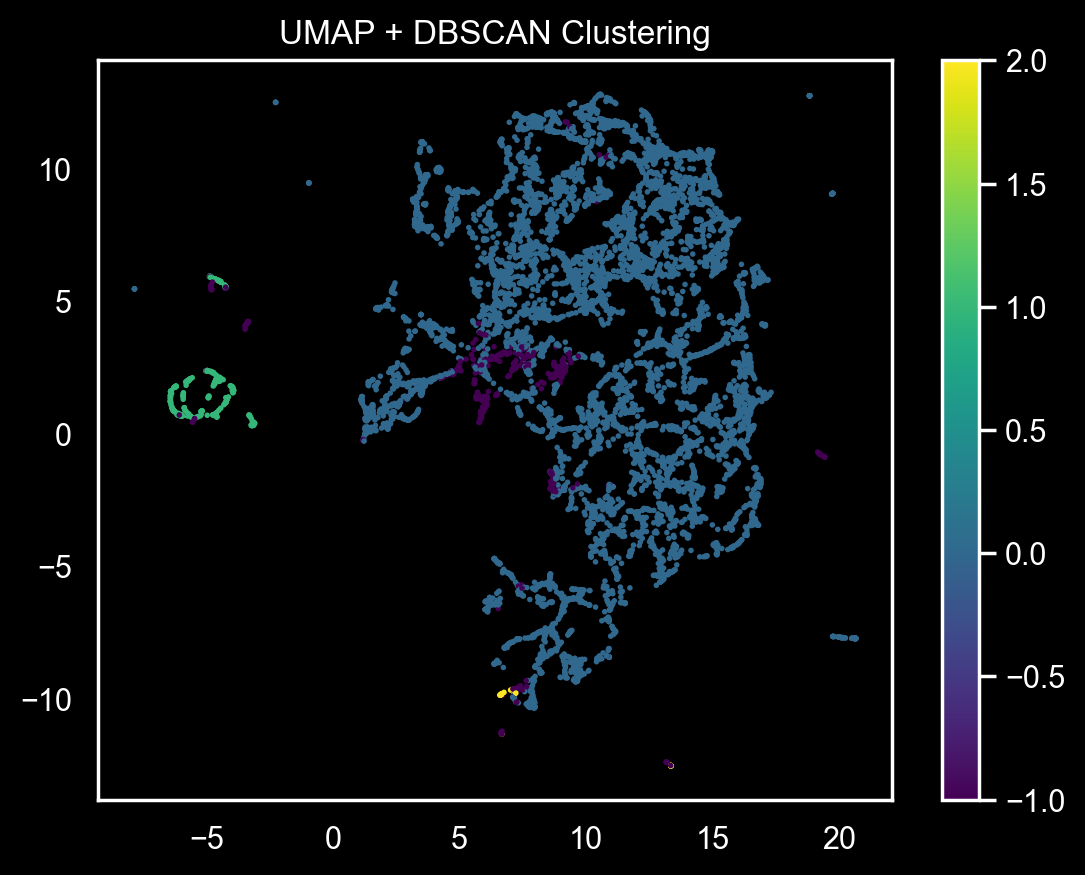

In [31]:
# try eps 1.25, min_samples 35
# should generate 3 clusters with silhouette score 0.5 and noise 528
dbscan = DBSCAN(eps=1.25, min_samples=35)
cluster_labels_dbscan = dbscan.fit_predict(X)
plt.scatter(umap_result[:, 0], umap_result[:, 1], c=cluster_labels_dbscan, cmap='viridis', s = 1)
plt.title('UMAP + DBSCAN Clustering')
plt.colorbar()
plt.show()

#### Look at dataframe to see if clusters make sense

In [32]:
# add column to housing_df_revised with gmm cluster label for each point
housing_df_revised['dbscan clusters'] = cluster_labels_dbscan
housing_df_revised

/var/folders/dr/_3zwgynx02q1l6yd2z7c_p3w0000gn/T/ipykernel_40829/2752202114.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  housing_df_revised['dbscan clusters'] = cluster_labels_dbscan


,Bedroom,Bathroom,Area,PPSq,LotArea,MarketEstimate,RentEstimate,ListedPrice,difference_listed_vs_estimate,distance_to_maj_city_miles,violent_crime,prop_crime,larceny,vehicle_theft,x_house_coord,y_house_coord,gmm clusters,kmeans clusters,dbscan clusters
0,3.0,2.0,1564.0,96.547315,0.2000,150500.0,1385.0,151000.0,500.0,87.664428,0.001893,0.027600,0.017277,0.002520,32.372746,-86.165115,2,0,0
1,3.0,2.0,2196.0,76.958106,0.6100,124700.0,1250.0,169000.0,44300.0,83.806091,0.001893,0.027600,0.017277,0.002520,32.395950,-86.269714,2,0,0
2,3.0,3.0,3693.0,54.156512,6.9000,188300.0,1201.0,200000.0,11700.0,91.920847,0.001893,0.027600,0.017277,0.002520,32.273514,-86.259340,0,0,0
3,3.0,2.0,1428.0,90.966387,0.2600,127500.0,1019.0,129900.0,2400.0,87.007986,0.001893,0.027600,0.017277,0.002520,32.337000,-86.299740,2,0,0
4,3.0,1.0,1050.0,65.714286,0.1600,66500.0,950.0,69000.0,2500.0,83.007626,0.001893,0.027600,0.017277,0.002520,32.403250,-86.285370,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9631,5.0,3.0,3068.0,128.748370,0.2200,381000.0,2495.0,395000.0,14000.0,143.591563,0.001845,0.008133,0.007043,0.000168,41.494328,-109.452580,2,0,0
9632,2.0,2.0,2008.0,343.625498,4.6000,689900.0,1672.0,690000.0,100.0,223.247715,0.002351,0.024521,0.017467,0.002687,42.860570,-106.109310,0,0,0
9633,4.0,2.0,2022.0,157.270030,0.1828,311100.0,1895.0,318000.0,6900.0,226.191583,0.002351,0.024521,0.017467,0.002687,42.865060,-106.276430,2,0,0
9634,3.0,3.0,2300.0,143.434783,0.1739,329500.0,1614.0,329900.0,400.0,226.233434,0.002351,0.024521,0.017467,0.002687,42.865440,-106.277450,2,0,0


In [33]:
# run groupby function by 'gmm clusters' to see mean of each cluster
housing_df_revised.groupby('dbscan clusters').mean()

,Bedroom,Bathroom,Area,PPSq,LotArea,MarketEstimate,RentEstimate,ListedPrice,difference_listed_vs_estimate,distance_to_maj_city_miles,violent_crime,prop_crime,larceny,vehicle_theft,x_house_coord,y_house_coord,gmm clusters,kmeans clusters
dbscan clusters,,,,,,,,,,,,,,,,,,
-1,4.212121,3.939394,4049.403409,490.448900,9.188743,1.912900e+06,7703.998106,2.025279e+06,112378.524621,242.803171,0.004941,0.032685,0.025062,0.002798,41.771419,-104.932638,0.670455,0.865530
0,3.429517,2.367823,2014.223719,196.264699,0.636206,3.775447e+05,2242.360461,3.807668e+05,3222.134231,89.595058,0.004117,0.026561,0.019901,0.002404,39.051944,-94.470154,1.671156,0.906746
1,3.210191,2.315287,1948.646497,222.996686,1.027342,4.133121e+05,2571.843949,4.200460e+05,6733.850318,1462.255427,0.007766,0.042742,0.032232,0.004319,62.252968,-149.262403,1.000000,1.000000
2,3.121212,2.212121,1676.515152,162.592689,0.318036,2.600424e+05,1895.242424,2.645848e+05,4542.393939,74.345361,0.016567,0.098695,0.076662,0.007072,37.223429,-81.833095,0.000000,3.000000


In [34]:
# check how many points are in each cluster
for i in housing_df_revised['gmm clusters'].unique():
    shape = housing_df_revised[housing_df_revised['gmm clusters'] == i].shape[0]
    print (f'Cluster {i} has {shape} observations')

Cluster 2 has 7305 observations
Cluster 0 has 1632 observations
Cluster 1 has 699 observations


- Observations
    - there is still a distinguishable relationship between clusters
    - however we see the expensive homes be classified as outliers, which is not ideal at all
    - the cluster sizes has a rather exponential decrease in size, which is also not very optimal

## HDBSCAN

#### Find the number of clusters to cluster

min cluster size: 8, min_samples: 8
number of cluster : 7
number of noise : 404
min cluster size: 8, min_samples: 9
number of cluster : 4
number of noise : 277
min cluster size: 8, min_samples: 10
number of cluster : 3
number of noise : 296
min cluster size: 8, min_samples: 11
number of cluster : 6
number of noise : 1539
min cluster size: 8, min_samples: 12
number of cluster : 6
number of noise : 1495
min cluster size: 9, min_samples: 8
number of cluster : 7
number of noise : 404
min cluster size: 9, min_samples: 9
number of cluster : 4
number of noise : 277
min cluster size: 9, min_samples: 10
number of cluster : 3
number of noise : 296
min cluster size: 9, min_samples: 11
number of cluster : 6
number of noise : 1539
min cluster size: 9, min_samples: 12
number of cluster : 6
number of noise : 1495
min cluster size: 10, min_samples: 8
number of cluster : 7
number of noise : 404
min cluster size: 10, min_samples: 9
number of cluster : 3
number of noise : 286
min cluster size: 10, min_sa

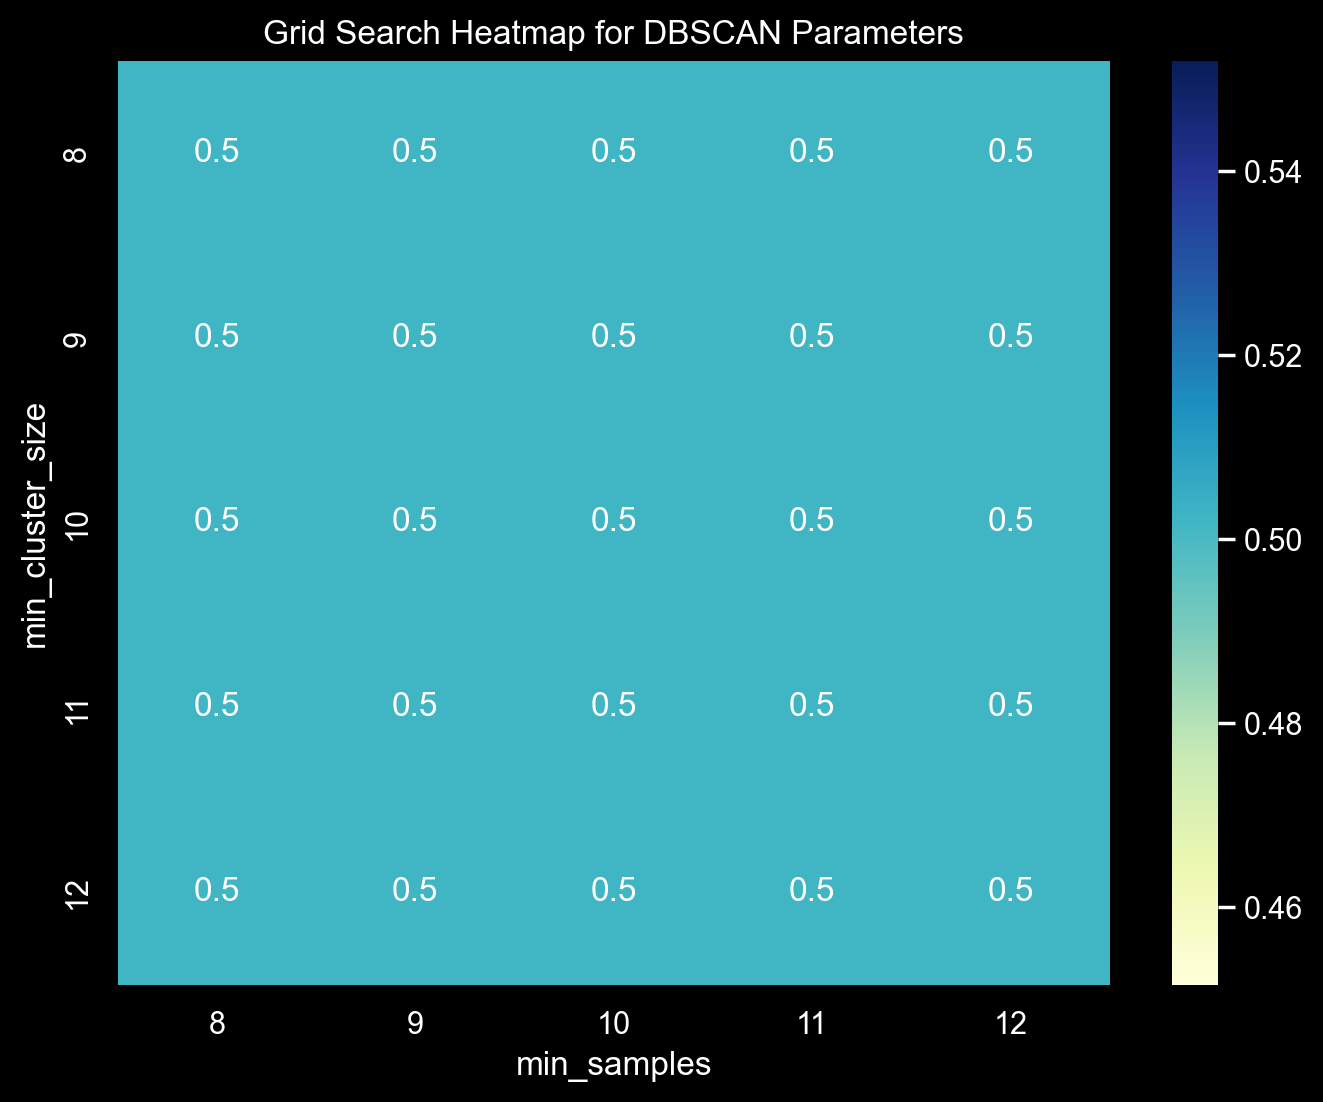

In [35]:
# decide parameters using gridsearch
# Define parameter grid
param_grid = {'min_cluster_size': [8,9,10,11,12],
              'min_samples': [8,9,10,11,12]}

# Initialize arrays to store silhouette scores
silhouette_scores = np.zeros((len(param_grid['min_cluster_size']), len(param_grid['min_samples'])))

# Iterate over parameter combinations
for i, params in enumerate(ParameterGrid(param_grid)):
    # Fit DBSCAN with current parameter combination
    hdbscan = HDBSCAN(**params)
    hdbscan.fit(X)
    labels = hdbscan.fit_predict(X)
    n_clusters_ = len(set(labels))-(1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    
    min_cluster_size_value = params['min_cluster_size']
    min_samples_value = params['min_samples']
    
    print(f"min cluster size: {min_cluster_size_value}, min_samples: {min_samples_value}")
    print (f'number of cluster : {n_clusters_}')
    print (f'number of noise : {n_noise_}') 
    
    # Compute silhouette score
    silhouette_avg = silhouette_score(X, dbscan.labels_)
    silhouette_scores[i // len(param_grid['min_samples']), i % len(param_grid['min_samples'])] = silhouette_avg

# Create heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(silhouette_scores, annot=True, cmap="YlGnBu", xticklabels=param_grid['min_samples'], yticklabels=param_grid['min_cluster_size'])
plt.xlabel('min_samples')
plt.ylabel('min_cluster_size')
plt.title('Grid Search Heatmap for DBSCAN Parameters')
plt.show()

#### Generate HDBSCAN clusters

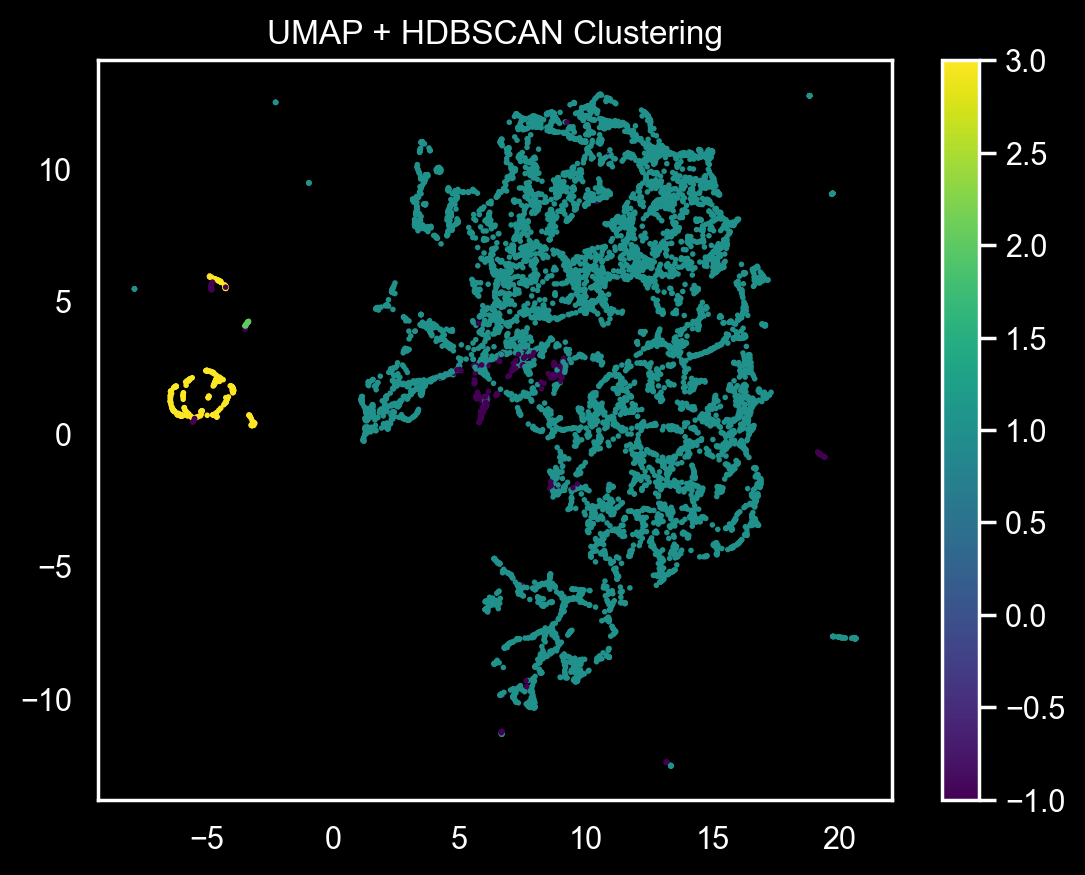

In [36]:
# try min_cluster_size 8, min_samples 9
# should generate 3 clusters with silhouette score 0.5 and noise 528
hdbscan = HDBSCAN(min_cluster_size=9, min_samples=9)
cluster_labels_hdbscan = hdbscan.fit_predict(X)
plt.scatter(umap_result[:, 0], umap_result[:, 1], c=cluster_labels_hdbscan, cmap='viridis', s = 1)
plt.title('UMAP + HDBSCAN Clustering')
plt.colorbar()
plt.show()

#### Look at dataframe to see if clusters make sense

In [37]:
# add column to housing_df_revised with gmm cluster label for each point
housing_df_revised['hdbscan clusters'] = cluster_labels_hdbscan
housing_df_revised

/var/folders/dr/_3zwgynx02q1l6yd2z7c_p3w0000gn/T/ipykernel_40829/1854836882.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  housing_df_revised['hdbscan clusters'] = cluster_labels_hdbscan


,Bedroom,Bathroom,Area,PPSq,LotArea,MarketEstimate,RentEstimate,ListedPrice,difference_listed_vs_estimate,distance_to_maj_city_miles,violent_crime,prop_crime,larceny,vehicle_theft,x_house_coord,y_house_coord,gmm clusters,kmeans clusters,dbscan clusters,hdbscan clusters
0,3.0,2.0,1564.0,96.547315,0.2000,150500.0,1385.0,151000.0,500.0,87.664428,0.001893,0.027600,0.017277,0.002520,32.372746,-86.165115,2,0,0,1
1,3.0,2.0,2196.0,76.958106,0.6100,124700.0,1250.0,169000.0,44300.0,83.806091,0.001893,0.027600,0.017277,0.002520,32.395950,-86.269714,2,0,0,1
2,3.0,3.0,3693.0,54.156512,6.9000,188300.0,1201.0,200000.0,11700.0,91.920847,0.001893,0.027600,0.017277,0.002520,32.273514,-86.259340,0,0,0,1
3,3.0,2.0,1428.0,90.966387,0.2600,127500.0,1019.0,129900.0,2400.0,87.007986,0.001893,0.027600,0.017277,0.002520,32.337000,-86.299740,2,0,0,1
4,3.0,1.0,1050.0,65.714286,0.1600,66500.0,950.0,69000.0,2500.0,83.007626,0.001893,0.027600,0.017277,0.002520,32.403250,-86.285370,2,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9631,5.0,3.0,3068.0,128.748370,0.2200,381000.0,2495.0,395000.0,14000.0,143.591563,0.001845,0.008133,0.007043,0.000168,41.494328,-109.452580,2,0,0,1
9632,2.0,2.0,2008.0,343.625498,4.6000,689900.0,1672.0,690000.0,100.0,223.247715,0.002351,0.024521,0.017467,0.002687,42.860570,-106.109310,0,0,0,1
9633,4.0,2.0,2022.0,157.270030,0.1828,311100.0,1895.0,318000.0,6900.0,226.191583,0.002351,0.024521,0.017467,0.002687,42.865060,-106.276430,2,0,0,1
9634,3.0,3.0,2300.0,143.434783,0.1739,329500.0,1614.0,329900.0,400.0,226.233434,0.002351,0.024521,0.017467,0.002687,42.865440,-106.277450,2,0,0,1


In [38]:
# run groupby function by 'gmm clusters' to see mean of each cluster
housing_df_revised.groupby('hdbscan clusters').mean()

,Bedroom,Bathroom,Area,PPSq,LotArea,MarketEstimate,RentEstimate,ListedPrice,difference_listed_vs_estimate,distance_to_maj_city_miles,violent_crime,prop_crime,larceny,vehicle_theft,x_house_coord,y_house_coord,gmm clusters,kmeans clusters,dbscan clusters
hdbscan clusters,,,,,,,,,,,,,,,,,,,
-1,4.411552,4.332130,4733.342960,582.061466,14.462206,2.638147e+06,10299.314079,2.834971e+06,196824.353791,232.236148,0.004585,0.029657,0.022630,0.002465,41.804720,-104.000074,0.841155,0.826715,-1.000000
0,4.888889,6.000000,5174.555556,907.763036,0.412771,4.580111e+06,17894.888889,4.591544e+06,11433.333333,35.736116,0.004204,0.025901,0.018513,0.003009,35.056721,-118.324624,1.000000,0.000000,-1.000000
1,3.442333,2.394167,2044.647444,200.529929,0.710573,3.926913e+05,2296.090667,3.963205e+05,3629.225889,90.158728,0.004184,0.027028,0.020275,0.002437,39.043523,-94.535378,1.635222,0.915000,-0.015556
2,3.500000,2.550000,1892.100000,300.354343,0.321249,5.371600e+05,2371.300000,5.504849e+05,13324.950000,817.710647,0.007589,0.044119,0.036167,0.002784,57.310659,-133.540933,1.000000,1.000000,-1.000000
3,3.224242,2.339394,1983.403030,223.155224,1.052137,4.214821e+05,2596.748485,4.283807e+05,6898.572727,1461.546007,0.007702,0.042590,0.032126,0.004316,62.217731,-149.285373,1.000000,1.000000,0.903030


In [39]:
# check how many points are in each cluster
for i in housing_df_revised['hdbscan clusters'].unique():
    shape = housing_df_revised[housing_df_revised['hdbscan clusters'] == i].shape[0]
    print (f'Cluster {i} has {shape} observations')

Cluster 1 has 9000 observations
Cluster 3 has 330 observations
Cluster -1 has 277 observations
Cluster 2 has 20 observations
Cluster 0 has 9 observations


# Comparisons across all clustering methods

- GMM
    - silhouette scores seem to be relatively consistent when we run the GMM multiple times
    - elbow point however fluctuates significantly when we run the elbow point graph multiple times
        - this may be a result of a different initialization point every time
    - In GMM we used 3 clusters where it had a silhouette score of 0.309, meanwhile the elbow point indicated that we should have used 4 clusters
    - the umap visualization seemed very homogenous between 2 clusters, however there was a clear separation with the third cluster. Note since the GMM was ran in 6 dimensiosn, projecting it onto a 2 dimensional umap may not be indicative of how well our clustering actually is.
    - Looking at means of each cluster, we see a clear distinction between all 3 clusters
    - however we see an exponental decrease in size of clusters as follows
        - Cluster 0: 8247 observations
        - Cluster 1: 1023 observations
        - Cluster 2: 366 observations
- K means
    - with K means we see consistency among the silhouette scores and the elbow point as both indicate that 4 clusters seems optimal. 4 clusters indicated a silhouette score of 0.317, which is better than that compared to GMM
    - when running the silhouette scores and elbow point multiple times, we get roughly the same result every time, indicating that K means may allow us to reproduce the data quite well
    - the umap visualization shows clear distinction between the 4 groups
    - Looking at the mean of each cluster, I believe that we see a much clearer distinction between clusters compared to GMM
    - however when we look at the cluster sizes, we still see this exponential decrease, but it seems a lot more gradual compared to GMM as follows:
        - Cluster 0: 6441 observations
        - Cluster 1: 377 observations
        - Cluster 2: 17 observations
        - Cluster 3: 2801 observations
    - Cluster size of 377 may be problematic, but a cluster size of 17 will definitely be problematic
    - another issue is the underlying issue in regards to kmeans, that being that we must assume spherial covariance with roughly equal variance among all clusters
    - Since we do not know the clear shape of our data, K means may not be ideal
- DBSCAN
    - DBSCAN is the best in terms of reproducibilty of clusters, as running the grid search heatmap producted the same results of same number of clusters, same number of noise points, and same silhouette score every time
    - Using DBSCAN paramters of eps = 1.25, and min_samples = 35, we got 3 clusters and a silhouette score of 0.5 which is the highest out of the other 2 algorithms.
    - The issue with DBSCAN however lies in how it generates noise points that does not cluster with the other points. Using the above paramters, we have generated 528 noise points which is around 5.5% of our data.
    - Looking at the umap visualization however, we do not see clear separation of clusters, however since we are projecting clustering from 6 dimensions down to 2 dimensions, our visualization may not be very indicative of how well our clustering actually is.
    - Looking at the mean of each cluster we see a distinguishable relationship between clusters
    - however there is one major issue that will rule us out of using DBSCAN, that being that it classifies the expensive houses as noise instead of clusters
    - looking at cluster sizes, we see this exponential decrease in size, more drastic that that of GMM as follows:
        - Cluster 0: 8761 observations
        - Cluster 1: 314 observations
        - Cluster 2: 33 observations
    - Cluster 1 may be problematic based on its size, but cluster 2 most definitely will cause issues as it is too small

### Conclusions
It seems that we will likely use pca reduced k means in order to train the model. It seems that 4 clusters seems to be better for classificaiton compared to the 3 used in both GMM and Kmeans. Kmeans has the most clear distinction between cluster out of all 3. In terms of silhouette scores, Kmeans is very similar to that of GMM, but because of the issue of noise, that being that DBSCAN classifies the expensive houses as noise, we will have to rule it out as we would like to include expensive homes as its own cluster, even though DBSCAN has significantly the best silhouette score. Another point is that K means has the least exponential decrease in cluster size. However the fact that one of the clusters was of size 17, may pose an issue when splitting up the data into our training and testing model
    

# Generate Training testing model

In [40]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(X, test_size = 0.2, random_state = 42)

In [41]:
# calculate silhouette scores
range_n_clusters = [2,3, 4, 5, 6, 7, 8, 9, 10]

for n_clusters in range_n_clusters:
    clusterer = cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X_train)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_train, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

/Users/elizabethlee/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 2 The average silhouette_score is : 0.2969035257011422


/Users/elizabethlee/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 3 The average silhouette_score is : 0.31304206164115345


/Users/elizabethlee/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 4 The average silhouette_score is : 0.3162974494566466


/Users/elizabethlee/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 5 The average silhouette_score is : 0.32647311947629065


/Users/elizabethlee/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 6 The average silhouette_score is : 0.28284180020773325


/Users/elizabethlee/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 7 The average silhouette_score is : 0.28295675164851025


/Users/elizabethlee/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 8 The average silhouette_score is : 0.2464686020028026


/Users/elizabethlee/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 9 The average silhouette_score is : 0.2435996161292812


/Users/elizabethlee/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 10 The average silhouette_score is : 0.22436415249382852


/Users/elizabethlee/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/elizabethlee/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/elizabethlee/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/elizabethlee/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packa

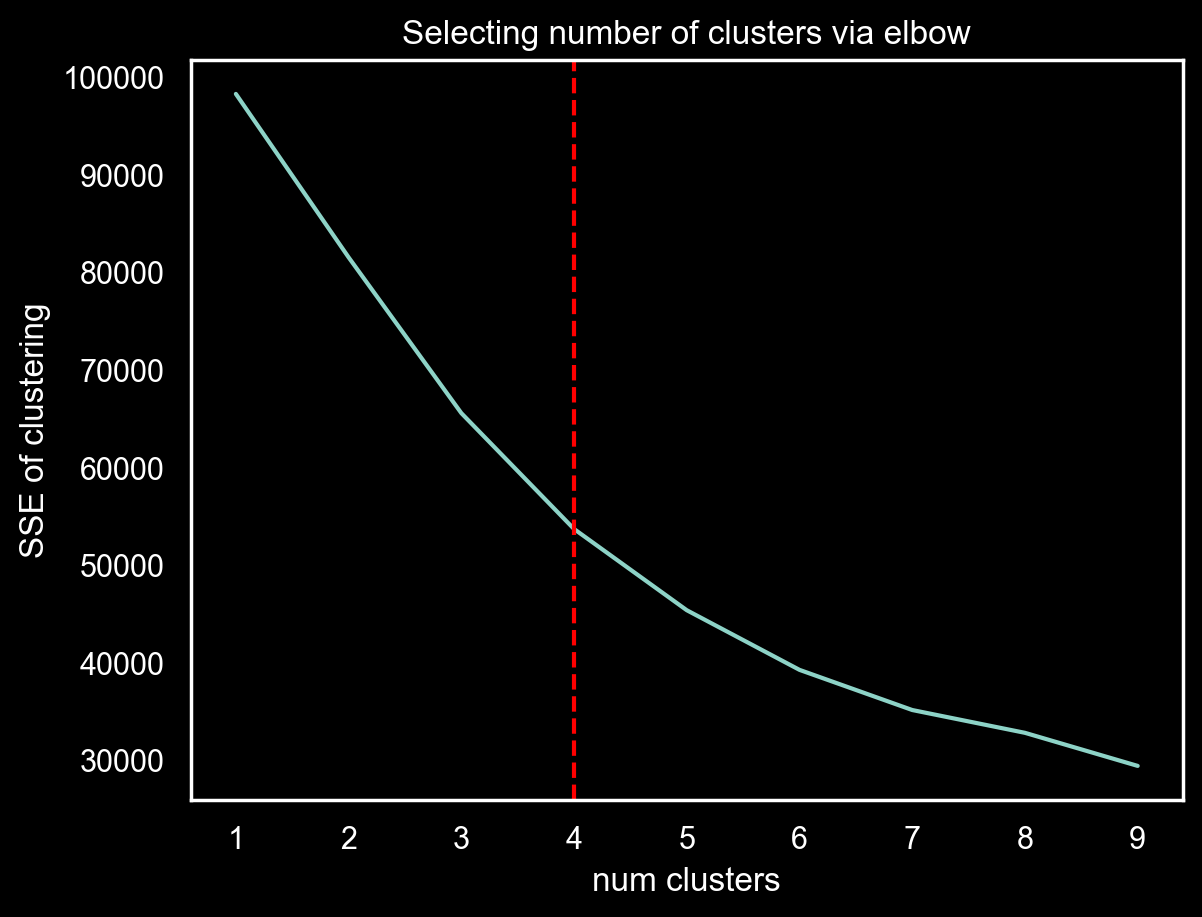

In [42]:
# plot the elbow point
sse=[]
maxk = 10
for k in range(1,maxk):
    clust = cluster.KMeans(n_clusters=k)
    clust.fit(X_train)
    sse.append(clust.inertia_)

# finds the location of max curvature (max of double derivative)
location = KneeLocator(range(1,maxk), sse, S=1.0, curve="convex", direction="decreasing")

plt.plot(range(1,maxk),sse)
plt.axvline(location.elbow, color="red", linestyle="--")

plt.xlabel('num clusters')
plt.ylabel('SSE of clustering')
plt.title('Selecting number of clusters via elbow');

In [43]:
clusterer_kmeans_train = cluster.KMeans(n_clusters=4, random_state=42)
cluster_labels_kmeans_train = clusterer_kmeans.fit_predict(X_train)

/Users/elizabethlee/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


/Users/elizabethlee/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


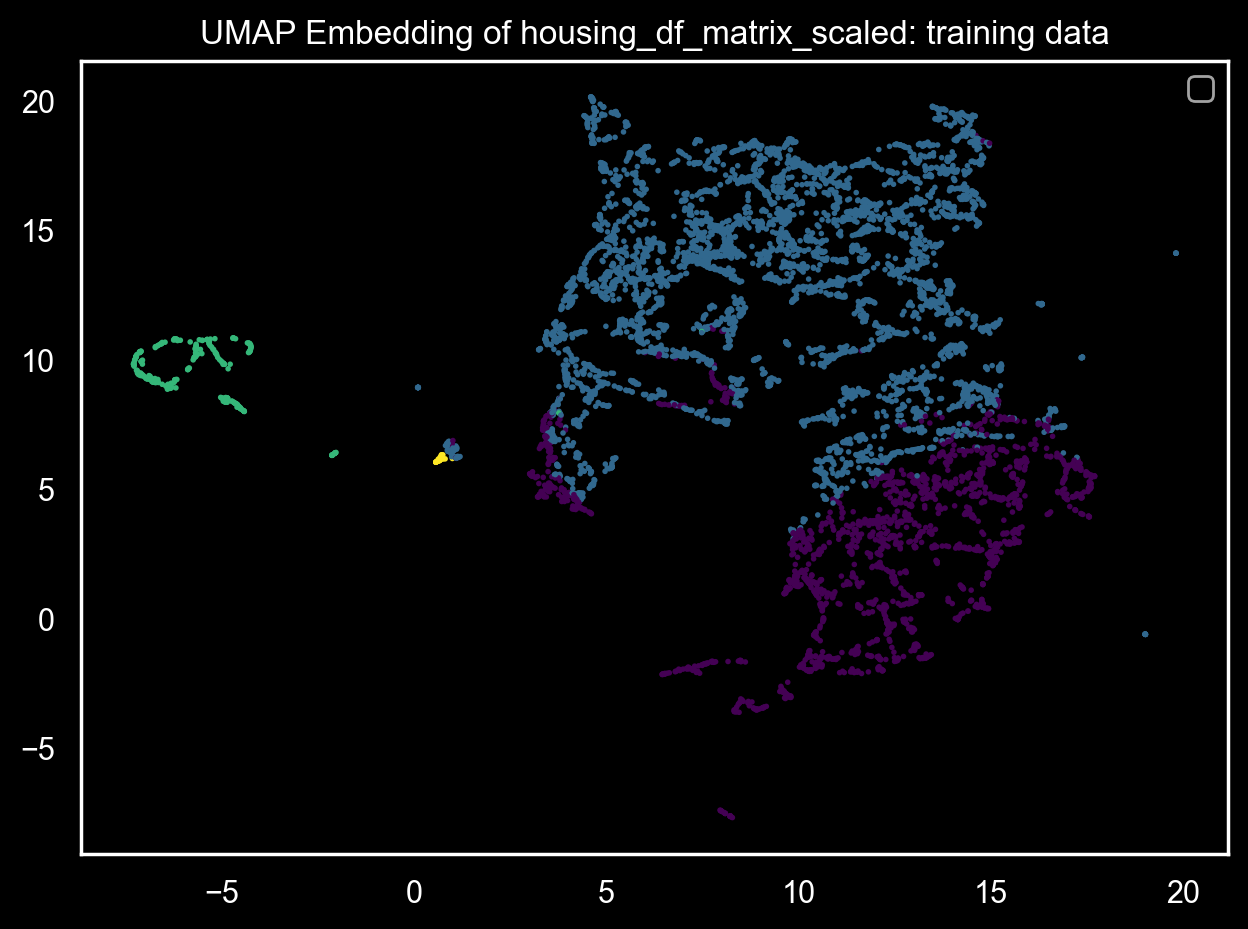

In [44]:
umap_model_train = umap.UMAP(n_neighbors=7, min_dist=0.1, metric='euclidean', random_state = 99, init = 'spectral')
umap_result_train = umap_model.fit_transform(X_train)
plt.scatter(umap_result_train[:, 0], umap_result_train[:, 1], c = cluster_labels_kmeans_train, cmap='viridis', s = 1)
plt.title('UMAP Embedding of housing_df_matrix_scaled: training data')
plt.legend()
plt.tight_layout()
plt.show()

In [45]:
cluster_label_test = clusterer_kmeans_train.fit_predict(X_test)

/Users/elizabethlee/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [46]:
silhouette_score_test = silhouette_score(X_test, cluster_label_test)
print(f'Silhouette score: {silhouette_score_test}')

Silhouette score: 0.3334222145844512


### Try testing HDBSCAN

min cluster size: 8, min_samples: 8
number of cluster : 8
number of noise : 334
min cluster size: 8, min_samples: 9
number of cluster : 4
number of noise : 241
min cluster size: 8, min_samples: 10
number of cluster : 3
number of noise : 270
min cluster size: 8, min_samples: 11
number of cluster : 3
number of noise : 284
min cluster size: 8, min_samples: 12
number of cluster : 6
number of noise : 1184
min cluster size: 9, min_samples: 8
number of cluster : 8
number of noise : 334
min cluster size: 9, min_samples: 9
number of cluster : 3
number of noise : 249
min cluster size: 9, min_samples: 10
number of cluster : 3
number of noise : 270
min cluster size: 9, min_samples: 11
number of cluster : 6
number of noise : 1166
min cluster size: 9, min_samples: 12
number of cluster : 6
number of noise : 1184
min cluster size: 10, min_samples: 8
number of cluster : 4
number of noise : 229
min cluster size: 10, min_samples: 9
number of cluster : 3
number of noise : 249
min cluster size: 10, min_sam

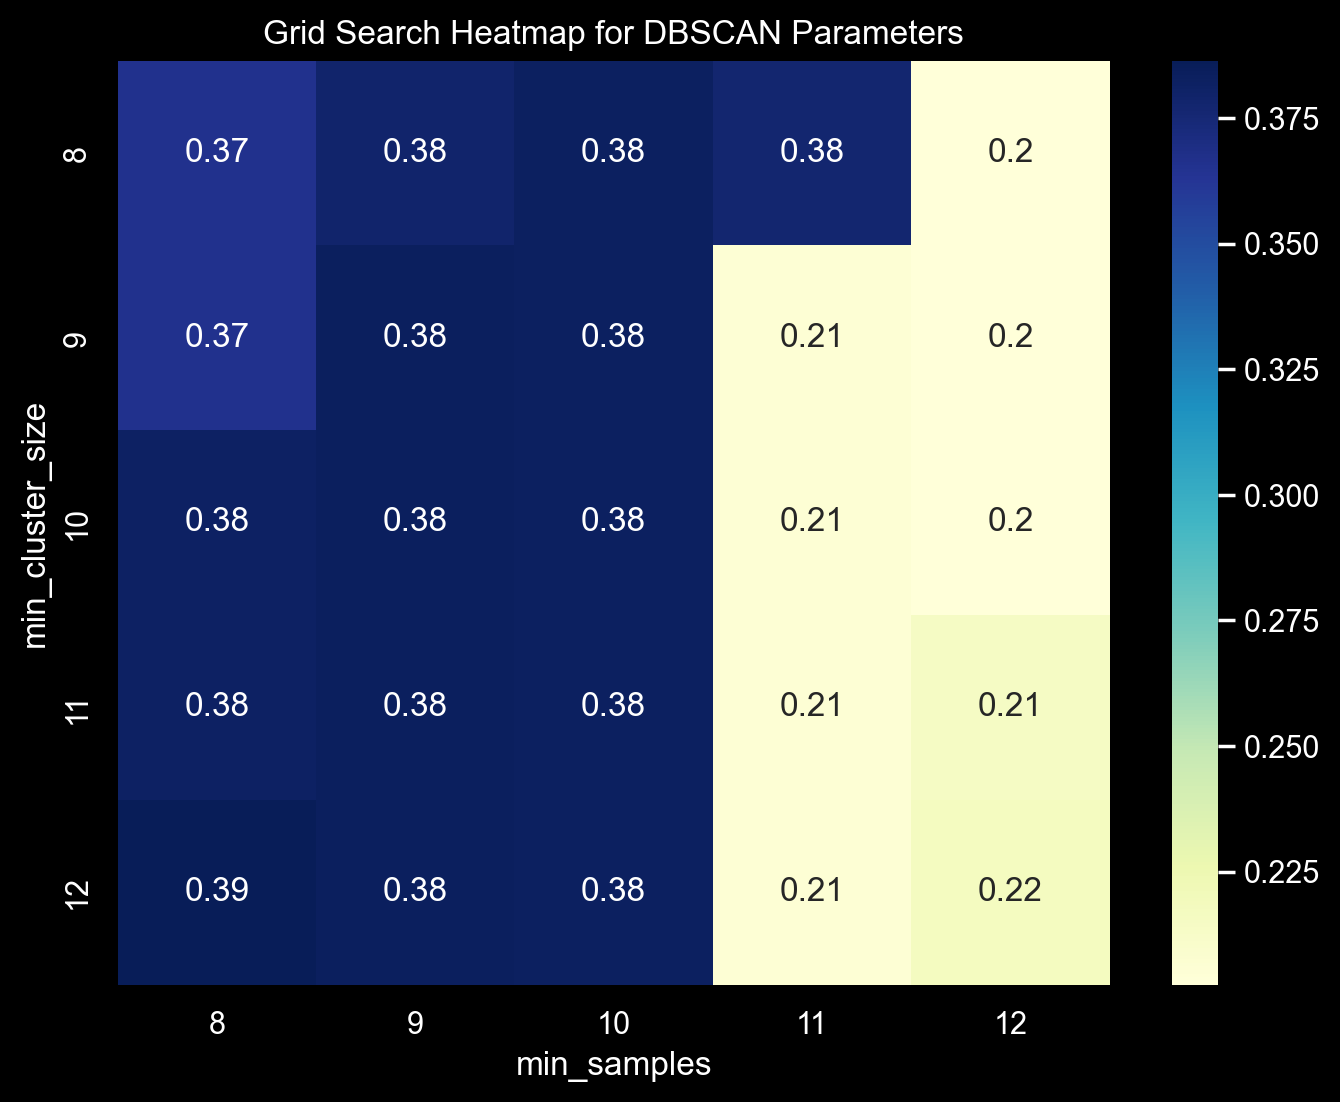

In [47]:
# decide parameters using gridsearch
# Define parameter grid
param_grid = {'min_cluster_size': [8,9,10,11,12],
              'min_samples': [8,9,10,11,12]}

# Initialize arrays to store silhouette scores
silhouette_scores = np.zeros((len(param_grid['min_cluster_size']), len(param_grid['min_samples'])))

# Iterate over parameter combinations
for i, params in enumerate(ParameterGrid(param_grid)):
    # Fit DBSCAN with current parameter combination
    hdbscan = HDBSCAN(**params)
    hdbscan.fit(X_train)
    labels = hdbscan.fit_predict(X_train)
    n_clusters_ = len(set(labels))-(1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    
    min_cluster_size_value = params['min_cluster_size']
    min_samples_value = params['min_samples']
    
    print(f"min cluster size: {min_cluster_size_value}, min_samples: {min_samples_value}")
    print (f'number of cluster : {n_clusters_}')
    print (f'number of noise : {n_noise_}') 
    
    # Compute silhouette score
    silhouette_avg = silhouette_score(X_train, hdbscan.labels_)
    silhouette_scores[i // len(param_grid['min_samples']), i % len(param_grid['min_samples'])] = silhouette_avg

# Create heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(silhouette_scores, annot=True, cmap="YlGnBu", xticklabels=param_grid['min_samples'], yticklabels=param_grid['min_cluster_size'])
plt.xlabel('min_samples')
plt.ylabel('min_cluster_size')
plt.title('Grid Search Heatmap for DBSCAN Parameters')
plt.show()

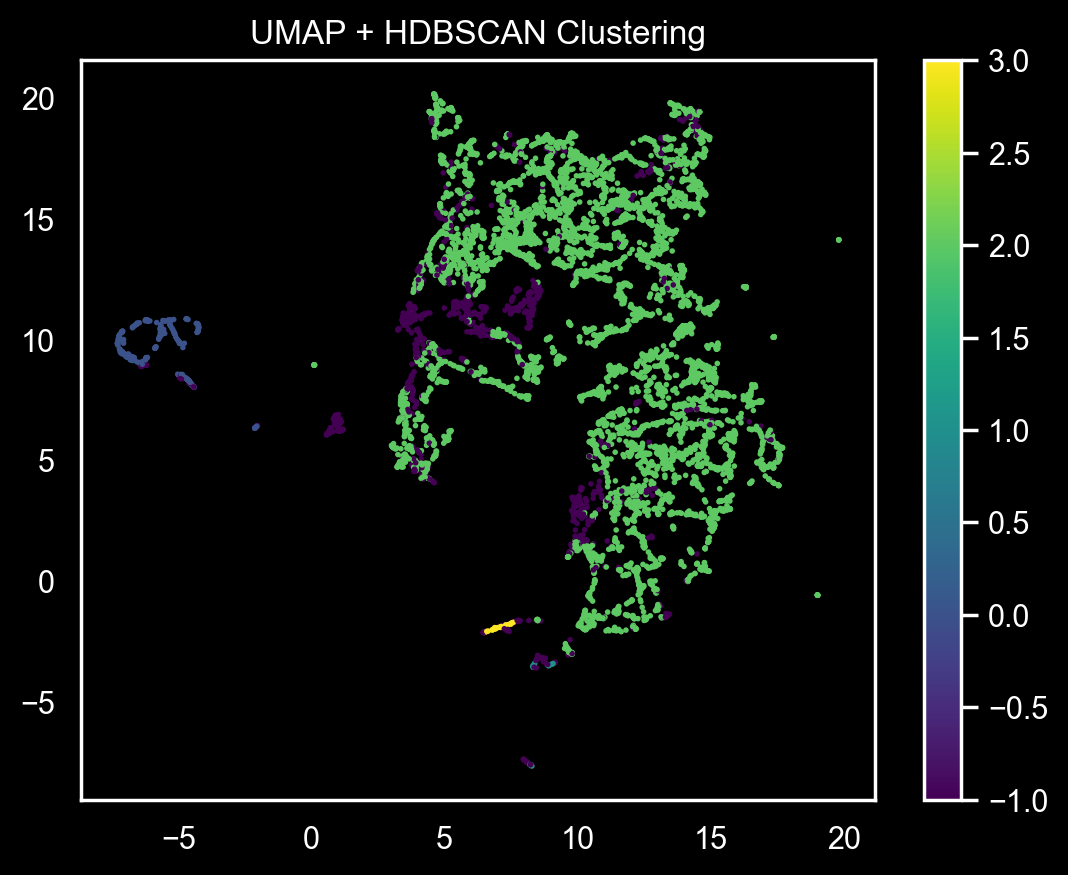

In [48]:
# try min_cluster_size 8, min_samples 9
# should generate 4 clusters with silhouette score 0.38 and noise 241
hdbscan_train = HDBSCAN(min_cluster_size=8, min_samples=9)
cluster_labels_hdbscan_train = hdbscan.fit_predict(X_train)
plt.scatter(umap_result_train[:, 0], umap_result_train[:, 1], c=cluster_labels_hdbscan_train, cmap='viridis', s = 1)
plt.title('UMAP + HDBSCAN Clustering')
plt.colorbar()
plt.show()

In [49]:
cluster_label_test_hdbscan = hdbscan_train.fit_predict(X_test)
silhouette_score_test_hdbscan = silhouette_score(X_test, cluster_label_test)
print(f'Silhouette score: {silhouette_score_test_hdbscan}')

Silhouette score: 0.3334222145844512


In [50]:
np.unique(cluster_label_test_hdbscan, return_counts = True)

(array([-1,  0,  1]), array([  53, 1807,   68]))

### 5 Fold Cross Validation

In [51]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# Initialize KFold for 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

silhouette_scores = []
for train_index, _ in kf.split(X_train):
    X_train_fold = X_train[train_index]
    
    clusterer_kmeans_train = cluster.KMeans(n_clusters=4, random_state=42)
    cluster_labels_kmeans_train = clusterer_kmeans.fit_predict(X_train_fold)
    
    # silhouette score for the current fold
    silhouette_avg = silhouette_score(X_train_fold, cluster_labels_kmeans_train)
    silhouette_scores.append(silhouette_avg)

# Calculate mean and standard deviation of silhouette scores across folds
mean_silhouette_score = np.mean(silhouette_scores)
std_silhouette_score = np.std(silhouette_scores)

/Users/elizabethlee/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/elizabethlee/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/elizabethlee/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/elizabethlee/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packa

In [52]:
print(mean_silhouette_score)
print(std_silhouette_score)
print(silhouette_scores)

0.3159626225861452
0.006745226835446725
[0.3177562930678386, 0.3123490111886785, 0.31372798942732727, 0.3279398245316622, 0.3080399947152195]


In [59]:
from sklearn.metrics import silhouette_score, make_scorer
kmeans = KMeans(n_clusters=4, random_state=42)
# Define silhouette scoring function
silhouette_scorer = make_scorer(silhouette_score, greater_is_better=True)

# Perform cross-validation
silhouette_scores = cross_val_score(kmeans,X , cv=5, scoring=silhouette_scorer)

print("Silhouette scores:", silhouette_score)
print("Average silhouette score:", np.mean(silhouette_scores))

/Users/elizabethlee/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/elizabethlee/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:839: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/elizabethlee/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 136, in __call__
    score = scorer._score(
TypeError: _score() missing 1 required positional argument: 'y_true'

  warnings.warn(
/Users/elizabethlee/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change

Silhouette scores: <function silhouette_score at 0x157a8d700>
Average silhouette score: nan


/Users/elizabethlee/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:839: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/elizabethlee/anaconda3/envs/COGS118B_WI24/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 136, in __call__
    score = scorer._score(
TypeError: _score() missing 1 required positional argument: 'y_true'

  warnings.warn(


In [56]:
silhouette_scores

array([nan, nan, nan, nan, nan])

In [58]:
X

array([[-0.99938987, -0.92542076, -0.85329571,  0.34067018, -0.05027862],
       [-0.76559471, -0.87975459, -0.9021912 ,  0.14409381,  0.03235443],
       [-0.067495  , -0.77949941, -1.0254976 , -0.95224082,  1.13826542],
       ...,
       [-0.29118442, -0.22357403,  0.82688853, -0.39231029, -0.22964889],
       [-0.18917742, -0.19673468,  0.79958399, -0.41141015, -0.17194345],
       [-0.3502025 , -0.95535822,  1.05409949, -0.66303957, -0.23277118]])